In [15]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import heapq
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm


def load_war_and_piece_chunks(fname, chunk_size=200):
    with open(fname, 'r', encoding="utf8") as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]

def save_texts_to_file(texts, out_file):
    with open(out_file, 'w', encoding="utf8") as outf:
        outf.write('\n'.join(texts))

def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part



In [2]:
all_chunks = load_war_and_piece_chunks('war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(all_chunks[1])

                           
                                   ТОМ 1

                               ЧАСТЬ ПЕРВАЯ
  

                  I.
             

    - Еh bien, mon prince. Genes et Lucques ne


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(len(train_texts))
print(len(test_texts))

5583
2393


In [5]:
BPE_MODEL_FILENAME = 'war_and_peace_bpe.yttm'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [6]:
TRAIN_TEXTS_FILENAME = 'war_and_peace_bpe_train.txt'

save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

In [7]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)


In [8]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л в р к , д м у п я г ь ы з б . ч й - ж e ш х ю s ц n a r i u t o щ э П l Н ф В А m d c ! ? О К Д Б p М " Р v ) ( ' С И ; 1 ё Т h : Я 2 q f Г ъ b g Э Ч 3 0 Е 4 I 5 ] [ j Л z 8 З M 6 7 9 У A V Ж x L Ф y X Ш B Х C J P S E k D N Q Ц R w O T Ю ` F U W H G K Ь Й Z * & # Щ ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра но ст ▁- ▁по ен ро ▁д ел ▁б ер ▁не во ко ка ▁м ▁ч ри ▁на ло ть на ли ла ▁з ▁е ▁т ▁у ре ва ни ся сь ак ▁что ет ▁ко ру ▁бы ны да ми ня ди ▁то хо ▁го ▁за ▁г ем ▁он ени ол ки ви ▁от каз ну ▁э е, ▁П та ти ши ▁ра ▁при ▁вы ▁Н му ▁ж ▁вс ов ле ▁В ▁про ▁А до ▁во ▁мо ля казал мо ▁как ма ▁его ры не ▁об ▁это ▁сказал сто ль ▁а й, ере ▁до ▁кото ▁О ▁я ▁К ▁сво ▁Д ▁кня ▁Б али у, ▁ни м, ше чи сти ▁но де по ста тел ча ▁из си ве лу ала ▁d ще ▁Ан вори че ▁ка ▁М .. ▁под ... es ска жи ша за лся ско я, ▁со лы енно зь ▁ли ou сть ▁ст ▁хо ▁ви ▁Пь ▁так ме ты ▁ру ря дел ▁p re ень га лю ▁Р ски уд сно ▁( ▁раз ги те ку ▁все же ▁l ▁ва со en ▁се вши ▁было ▁c вал on ту ▁С гда бе ▁И тель

In [9]:
print(tokenizer.encode(train_texts[:1]))

[[961, 220, 232, 871, 152, 180, 175, 26, 157, 273, 30, 269, 17, 172, 166, 687, 183, 506, 151, 539, 260, 372, 477, 165, 164, 24, 7, 180, 19, 411, 27, 159, 428, 194, 183, 368, 12, 240, 16, 283, 411, 167, 211, 198, 178, 27, 159, 873, 190, 225, 459, 733, 265, 986, 183, 817, 399, 773, 159, 540, 533, 77, 159, 841, 686, 153, 652, 23, 160, 970, 27, 494, 246, 29, 225, 215, 362, 368, 9, 150]]


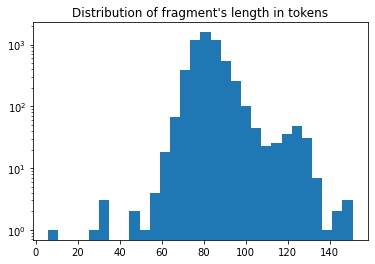

In [11]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True) #begin of seq, end of seq
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title("Distribution of fragment's length in tokens")
plt.yscale('log')

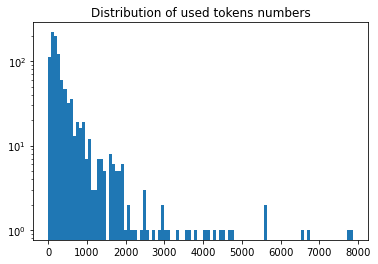

In [12]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Distribution of used tokens numbers')
plt.yscale('log')

In [13]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Number with unknown N-gramms', unknown_subwords_in_test)

Number with unknown N-gramms 2


In [16]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [17]:
train_dataset[0]

(array([  2, 961, 220, 232, 871, 152, 180, 175,  26, 157, 273,  30, 269,
         17, 172, 166, 687, 183, 506, 151, 539, 260, 372, 477, 165, 164,
         24,   7, 180,  19, 411,  27, 159, 428, 194, 183, 368,  12, 240,
         16, 283, 411, 167, 211, 198, 178,  27, 159, 873, 190, 225, 459,
        733, 265, 986, 183, 817, 399, 773, 159, 540, 533,  77, 159, 841,
        686, 153, 652,  23, 160, 970,  27, 494, 246,  29, 225, 215, 362,
        368,   9]),
 array([961, 220, 232, 871, 152, 180, 175,  26, 157, 273,  30, 269,  17,
        172, 166, 687, 183, 506, 151, 539, 260, 372, 477, 165, 164,  24,
          7, 180,  19, 411,  27, 159, 428, 194, 183, 368,  12, 240,  16,
        283, 411, 167, 211, 198, 178,  27, 159, 873, 190, 225, 459, 733,
        265, 986, 183, 817, 399, 773, 159, 540, 533,  77, 159, 841, 686,
        153, 652,  23, 160, 970,  27, 494, 246,  29, 225, 215, 362, 368,
          9, 150]))

In [18]:
tokenizer.decode(list(train_dataset[0]))

[', радостно и злобно из-под черных усов оскаливая свои белые зубы. - Я бы убил его, кабы не отняли. - Да что ж ты кричишь, успокойся, - говорил Ростов: - вот опять кровь пошла. Постой же, перебинто',
 'радостно и злобно из-под черных усов оскаливая свои белые зубы. - Я бы убил его, кабы не отняли. - Да что ж ты кричишь, успокойся, - говорил Ростов: - вот опять кровь пошла. Постой же, перебинто<EOS>']

In [23]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])